<a href="https://colab.research.google.com/github/karu-bee/ml_interpret_book/blob/main/ch2/ch2_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. 線形回帰モデルを通して「解釈性」を理解する

In [1]:
import sys
import warnings
from dataclasses import dataclass
from typing import Any  # 型ヒント用
from __future__ import annotations  # 型ヒント用

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import japanize_matplotlib  # matplotlibの日本語表示対応

# 自作モジュール
sys.path.append("..")

import matplotlib.pyplot as plt
import seaborn as sns

def get_visualization_setting():
    setting = {
        'style': 'white',
        'palette': 'deep',
        'font': 'IPAexGothic',
        'rc': {
            'figure.dpi': 300,
            'figure.figsize': (6, 4),
            'axes.spines.right': False,
            'axes.spines.top': False,
            'axes.linewidth': .8,
            'axes.grid': True,
            'grid.color': '.8',
            'grid.linewidth': .5,
            'grid.linestyle': 'dotted',
            'axes.edgecolor': '.3',
            'axes.labelcolor': '.3',
            'xtick.color': '.3',
            'ytick.color': '.3',
            'text.color': '.3',
            'figure.constrained_layout.use': True}}
    
    return setting


#from mli.visualize import get_visualization_setting

np.random.seed(42)
pd.options.display.float_format = "{:.2f}".format
sns.set(**get_visualization_setting())
warnings.simplefilter("ignore")  # warningsを非表示に

In [2]:
from sklearn.datasets import load_boston


# データセットの読み込み
boston = load_boston()

# データセットはdictで与えられる
# dataに特徴量が、targetに目的変数が格納されている
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


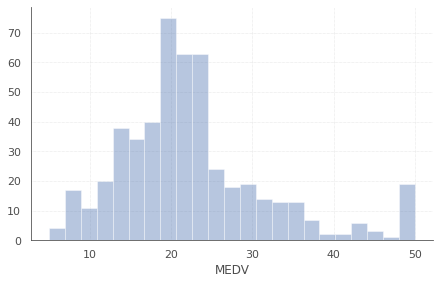

In [3]:
def plot_histogram(x, title=None, x_label=None):
    """与えられた特徴量のヒストグラムを作成"""
    
    fig, ax = plt.subplots()
    sns.distplot(x, kde=False, ax=ax)
    fig.suptitle(title)
    ax.set_xlabel(x_label)

    fig.show()


plot_histogram(y, #title="目的変数の分布",
               x_label="MEDV")

In [4]:
# 特徴量を出力
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33


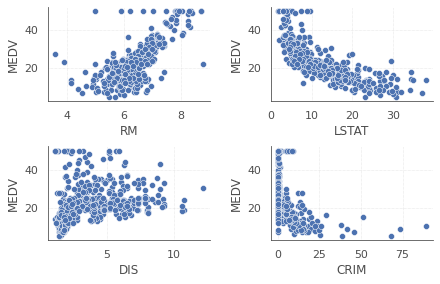

In [5]:
def plot_scatters(X, y, title=None):
    """目的変数と特徴量の散布図を作成"""
    
    cols = X.columns
    fig, axes = plt.subplots(nrows=2, ncols=2)

    for ax, c in zip(axes.ravel(), cols):
        sns.scatterplot(X[c], y, ci=None, ax=ax)
        ax.set(ylabel="MEDV")

    fig.suptitle(title)
    
    fig.show()


plot_scatters(
    X[["RM", "LSTAT", "DIS", "CRIM"]], 
    y, 
    #title="目的変数と各特徴量の関係"
)

In [6]:
from sklearn.model_selection import train_test_split
import joblib  # pickleデータの書き出しと読み込み


# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 後で使えるようにデータを書き出しておく
joblib.dump(
    [X_train, X_test, y_train, y_test], 
    #filename="../data/boston_housing.pkl"
    filename="boston_housing.pkl"
)

['boston_housing.pkl']

In [7]:
from sklearn.linear_model import LinearRegression


# 学習
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [8]:
from sklearn.metrics import mean_squared_error, r2_score


def regression_metrics(estimator, X, y):
    """回帰精度の評価指標をまとめて返す関数"""

    # テストデータで予測
    y_pred = estimator.predict(X)

    # 評価指標をデータフレームにまとめる
    df = pd.DataFrame(
        data={
            "RMSE": [mean_squared_error(y, y_pred, squared=False)],
            "R2": [r2_score(y, y_pred)],
        }
    )

    return df


# 精度評価
regression_metrics(lm, X_test, y_test)

,RMSE,R2
0,4.93,0.67


In [9]:
def get_coef(estimator, var_names):
    """特徴量名と回帰係数が対応したデータフレームを作成する"""
    
    # 切片含む回帰係数と特徴量の名前を抜き出してデータフレームにまとめる
    df = pd.DataFrame(
        data={"coef": [estimator.intercept_] + estimator.coef_.tolist()}, 
        index=["intercept"] + var_names
    )
    
    return df


# 回帰係数の取り出し
df_coef = get_coef(lm, X.columns.tolist())
df_coef.T

,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coef,30.25,-0.11,0.03,0.04,2.78,-17.20,4.44,-0.01,-1.45,0.26,-0.01,-0.92,0.01,-0.51


In [10]:
# 元のデータを上書きしないようにコピーしておく
X_train2 = X_train.copy()
X_test2 = X_test.copy()

# 2乗項を追加
X_train2["LSTAT2"] = X_train2["LSTAT"] ** 2
X_test2["LSTAT2"] = X_test2["LSTAT"] ** 2

# 学習
lm2 = LinearRegression()
lm2.fit(X_train2, y_train)

# 精度評価
regression_metrics(lm2, X_test2, y_test)

,RMSE,R2
0,4.22,0.76


In [11]:
# 2乗項を追加した場合の回帰係数を出力
df_coef2 = get_coef(lm2, X_train2.columns.tolist())
df_coef2.T

,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,LSTAT2
coef,40.16,-0.13,0.01,0.05,2.48,-15.91,3.44,0.02,-1.26,0.26,-0.01,-0.79,0.01,-1.72,0.03


In [12]:
# データを出力
X_test2.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,LSTAT2
173,0.09,0.00,4.05,0.00,0.51,6.42,84.10,2.65,5.00,296.00,16.60,395.50,9.04,81.72
274,0.06,40.00,6.41,1.00,0.45,6.76,32.90,4.08,4.00,254.00,17.60,396.90,3.53,12.46
491,0.11,0.00,27.74,0.00,0.61,5.98,98.80,1.87,4.00,711.00,20.10,390.11,18.07,326.52
72,0.09,0.00,10.81,0.00,0.41,6.07,7.80,5.29,4.00,305.00,19.20,390.91,5.52,30.47
452,5.09,0.00,18.10,0.00,0.71,6.30,91.80,2.37,24.00,666.00,20.20,385.09,17.27,298.25


In [13]:
def calc_lstat_impact(df, lstat):
    """LSTATが１単位増加したときに予測値に与える影響"""

    return (df.loc["LSTAT"] + 2 * df.loc["LSTAT2"] * lstat).values[0]

# インスタンス274の場合
i = 274
lstat = X_test2.loc[i, "LSTAT"]
impact = calc_lstat_impact(df_coef2, lstat)

print(f"インスタンス{i}でLSTATが1単位増加したときの効果(LSTAT={lstat:.2f})：{impact:.2f}")

インスタンス274でLSTATが1単位増加したときの効果(LSTAT=3.53)：-1.48


In [14]:
# インスタンス491の場合
i = 491
lstat = X_test2.loc[i, "LSTAT"]
impact = calc_lstat_impact(df_coef2, lstat)

print(f"インスタンス{i}でLSTATが1単位増加したときの効果(LSTAT={lstat:.2f})：{impact:.2f}")

インスタンス491でLSTATが1単位増加したときの効果(LSTAT=18.07)：-0.50


In [15]:
# 回帰係数を出力
df_coef.T

,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coef,30.25,-0.11,0.03,0.04,2.78,-17.20,4.44,-0.01,-1.45,0.26,-0.01,-0.92,0.01,-0.51


In [16]:
# 特徴量ごとの値の範囲を知るため、最大値と最小値の差分を確認
df_range = pd.DataFrame(data={"range": X_train.max() - X_train.min()})
df_range.T

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
range,88.97,100.00,27.00,1.00,0.49,4.92,97.10,11.00,23.00,524.00,9.40,396.58,36.24


In [17]:
from sklearn.preprocessing import StandardScaler


# 訓練データから平均と分散を計算
ss = StandardScaler()
ss.fit(X_train)

# 標準化：平均を引いて標準偏差で割る
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# 学習
lm_ss = LinearRegression()
lm_ss.fit(X_train_ss, y_train)

# 精度評価
regression_metrics(lm_ss, X_test_ss, y_test)

,RMSE,R2
0,4.93,0.67


In [18]:
# 標準化された回帰係数を出力
df_coef_ss = get_coef(lm_ss, X_train.columns.tolist())
df_coef_ss.T

,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coef,22.80,-1.00,0.70,0.28,0.72,-2.02,3.15,-0.18,-3.08,2.25,-1.77,-2.04,1.13,-3.61


In [19]:
# 先頭のインスタンスを取り出す
Xi = X_test.iloc[[0]]

print(f"インスタンス{Xi.index[0]}に対する予測値：{lm.predict(Xi)[0]:.2f}")

インスタンス173に対する予測値：29.00


In [20]:
# 回帰係数を出力
df_coef.T

,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coef,30.25,-0.11,0.03,0.04,2.78,-17.20,4.44,-0.01,-1.45,0.26,-0.01,-0.92,0.01,-0.51


In [21]:
# インスタンス173の特徴量を出力
Xi

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
173,0.09,0.00,4.05,0.00,0.51,6.42,84.10,2.65,5.00,296.00,16.60,395.50,9.04


In [22]:
# 各特徴量の値x回帰係数
Xi * df_coef.drop("intercept").values.T

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
173,-0.01,0.00,0.16,0.00,-8.77,28.48,-0.53,-3.83,1.31,-3.15,-15.20,4.88,-4.60


In [23]:
from sklearn.ensemble import RandomForestRegressor


# Random Forestの学習
# n_jobs=-1とすると利用可能なすべてのCPUを使って計算を並列化してくれる
rf = RandomForestRegressor(n_jobs=-1, random_state=42)

rf.fit(X_train, y_train)

# モデルの書き出し
joblib.dump(rf, "boston_housing_rf.pkl")
#joblib.dump(rf, "../model/boston_housing_rf.pkl")

# テストデータで精度評価
regression_metrics(rf, X_test, y_test)

,RMSE,R2
0,2.81,0.89
